## Softmax Function
- https://www.jianshu.com/p/cb93d5e39bca

In [2]:
import numpy as np
def softmax_function(x):
    return np.exp(x) / np.sum(np.exp(x))


y = np.array([0.8,0.5,0.7,0.6,0.9,1.5])

softmax_function(y)


array([0.15189927, 0.11252975, 0.13744415, 0.12436461, 0.16787466,
       0.30588757])

In [4]:
import numpy as np
def softmax_function_with_temperature(x, temperature):
    return np.exp(x/temperature) / np.sum(np.exp(x/temperature))

softmax_function_with_temperature(y,10)

array([0.16602326, 0.16111653, 0.1643713 , 0.16273578, 0.16769182,
       0.17806131])

In [5]:
softmax_function_with_temperature(y,0.5)

array([0.12027232, 0.06600685, 0.09847065, 0.08062095, 0.14690094,
       0.4877283 ])

## Time Series Analysis in Python
- https://www.kaggle.com/rakannimer/air-passenger-prediction
- https://github.com/ywchiu/cdc_course/blob/master/slides/20180724%20-%20R%20%E8%AA%9E%E8%A8%80%E8%88%87%E6%A9%9F%E5%99%A8%E5%AD%B8%E7%BF%92(%E4%B8%83).pdf

## Normal Distribution

Populating the interactive namespace from numpy and matplotlib


C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:11: MatplotlibDeprecationWarning: scipy.stats.norm.pdf
  # This is added back by InteractiveShellApp.init_path()


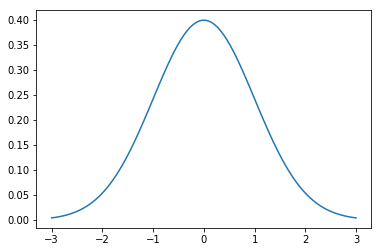

In [7]:
% pylab inline
import matplotlib.pyplot as plt
import numpy as np
import matplotlib.mlab as mlab
import math

mu       = 0
variance = 1
sigma = math.sqrt(variance)
x = np.linspace(mu - 3*sigma, mu + 3*sigma, 100)
plt.plot(x,mlab.normpdf(x, mu, sigma))
plt.show()

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:6: MatplotlibDeprecationWarning: scipy.stats.norm.pdf
  


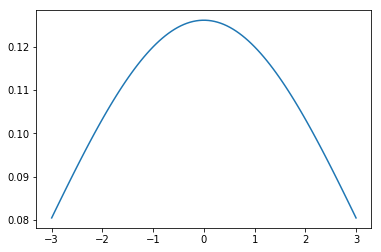

In [9]:
mu       = 0
variance = 10
sigma = math.sqrt(variance)
#x = np.linspace(mu - 3*sigma, mu + 3*sigma, 100)
x = np.linspace(mu - 3, mu + 3, 100)
plt.plot(x,mlab.normpdf(x, mu, sigma))
plt.show()

## 使用VAE 生成圖片

### 引用套件

In [10]:
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt
import os
import cv2

from   scipy.stats import norm
import matplotlib.image as matimg
import glob

from keras.datasets import mnist
from keras.layers import Input, Dense, Lambda
from keras.models import Model
from keras import backend as K
from keras import objectives

C:\ProgramData\Anaconda3\lib\site-packages\h5py\__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


### 設定網路參數

In [12]:
#math.sqrt(12288)

In [25]:
num_training_examples = 1200
num_testing_examples  = 125

batch_size   = 25
original_dim = 64 * 64 * 3 #this is same as image_vector_size
latent_dim   = 2
intermediate_dim = 256
epsilon_std  = 1.0

### 讀取圖片

In [26]:
def load_image(path):
    img = matimg.imread(path)
    return img

#following code loads data from local repo
#directory should have two subfolders, with name train and test
def load_local_data(path):
    paths = glob.glob(os.path.join(path + "/train", "*.jpg"))
    X_train = np.array( [ load_image(p) for p in paths ] )

    paths = glob.glob(os.path.join(path + "/test", "*.jpg"))
    X_test = np.array( [ load_image(p) for p in paths ] )
   
    return X_train, X_test

### 建立 Encoder

In [27]:
x = Input(batch_shape=(batch_size, original_dim))
h = Dense(intermediate_dim, activation='relu')(x)
z_mean    = Dense(latent_dim)(h)
z_log_var = Dense(latent_dim)(h)

### 取樣函數

In [28]:
def sampling(args):
    z_mean, z_log_var = args
    epsilon = K.random_normal(shape=(batch_size, latent_dim), mean=0.,stddev=epsilon_std)
    return z_mean + K.exp(z_log_var / 2) * epsilon

### 建立解碼器

In [29]:
z = Lambda(sampling, output_shape=(latent_dim,))([z_mean, z_log_var])

# we instantiate these layers separately so as to reuse them later
decoder_h    = Dense(intermediate_dim, activation='relu')
decoder_mean = Dense(original_dim, activation='sigmoid')
h_decoded    = decoder_h(z)
x_decoded_mean = decoder_mean(h_decoded)

### 計算 VAE 損失

#### KL Divergence
- https://zh.wikipedia.org/wiki/%E7%9B%B8%E5%AF%B9%E7%86%B5

In [30]:
# modified calculation of loss
def vae_loss(x, x_decoded_mean):
    #xent_loss = reconstruction error
    xent_loss = original_dim * objectives.binary_crossentropy(x, x_decoded_mean)
    
    kl_loss = - 0.5 * K.sum(1 + z_log_var - K.square(z_mean) - K.exp(z_log_var), axis=-1)
    return xent_loss + kl_loss

### 建立 VAE 模型

In [31]:

# vae model# vae mo 
vae = Model(x, x_decoded_mean)
vae.compile(optimizer='rmsprop', loss=vae_loss)

# if want to train with data from local repo
path="newyorkB"
(x_train, x_test) = load_local_data(path)
print(x_train.shape)

x_train = x_train.astype('float32') / 255.
x_test  = x_test.astype('float32')  / 255.
x_train = x_train.reshape((len(x_train), np.prod(x_train.shape[1:])))
x_test  = x_test.reshape((len(x_test), np.prod(x_test.shape[1:])))



(1200, 64, 64, 3)


In [23]:
x_train.shape

(1200, 12288)

In [32]:
x_test.shape

(125, 12288)

In [33]:
#to train the model

vae.fit(x_train, x_train,
        shuffle=True,
        nb_epoch=50,
        batch_size=batch_size,
        validation_data=(x_test, x_test))

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:7: UserWarning: The `nb_epoch` argument in `fit` has been renamed `epochs`.
  import sys


Train on 1200 samples, validate on 125 samples
Epoch 1/50
1200/1200 [==============================] - 5s 4ms/step - loss: 7420.7935 - val_loss: 6730.0476
Epoch 2/50
1200/1200 [==============================] - 4s 4ms/step - loss: 6676.4961 - val_loss: 7327.1841
Epoch 3/50
1200/1200 [==============================] - 4s 4ms/step - loss: 6794.7264 - val_loss: 6647.2418
Epoch 4/50
1200/1200 [==============================] - 4s 4ms/step - loss: 6564.4655 - val_loss: 7254.8745
Epoch 5/50
1200/1200 [==============================] - 4s 4ms/step - loss: 6586.0758 - val_loss: 6530.5852
Epoch 6/50
1200/1200 [==============================] - 4s 4ms/step - loss: 6607.7318 - val_loss: 6586.8163
Epoch 7/50
1200/1200 [==============================] - 4s 4ms/step - loss: 6657.1226 - val_loss: 6587.0153
Epoch 8/50
1200/1200 [==============================] - 4s 4ms/step - loss: 6453.3832 - val_loss: 7214.9445
Epoch 9/50
1200/1200 [==============================] - 5s 4ms/step - loss: 6562.6593 - v

### HDF5
- https://support.hdfgroup.org/HDF5/

In [34]:
vae.save_weights('vae_landscape_100.h5')

In [36]:
vae.load_weights('vae_landscape_100.h5')

### 產生生成器

In [37]:
# build a model to project inputs on the latent space
encoder = Model(x, z_mean)

# display a 2D plot of the digit classes in the latent space
x_test_encoded = encoder.predict(x_test, batch_size=batch_size)

# build a face generator that can sample from the learned distribution
decoder_input = Input(shape=(latent_dim,))
_h_decoded      = decoder_h(decoder_input)
_x_decoded_mean = decoder_mean(_h_decoded)
generator = Model(decoder_input, _x_decoded_mean)

### 圖片生成

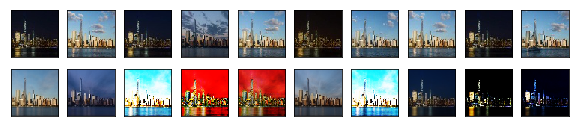

In [45]:
img_size = 64

# following values can generate some good skyline images
samples_encoded = [[5.55, -3.33], [-1.11, 10], [120, 13.3], [33.33, -77.77], [11.11, -33.33], [11.11, 11.11], [100, -33.33], [-7.77, -1.11], [-33.33, -11.11], [-33.33, 11.11]]
samples         = x_test[15:25]


# code to create a result.png with generated faces
plt.figure(figsize=(10, 2))

for i, yi in enumerate(samples_encoded):
    z_sample = np.array([[yi[0], yi[1]]])
    x_decoded = generator.predict(z_sample)
    x_decoded = x_decoded
    #print x_decoded.shape
    face = x_decoded[0].reshape(img_size, img_size, 3)


    ax1 = plt.subplot(2, 10, i + 1)
    plt.imshow(samples[i].reshape(img_size, img_size, 3))
    ax1.get_xaxis().set_visible(False)
    ax1.get_yaxis().set_visible(False)

    ax = plt.subplot(2, 10, i + 10 + 1)
    plt.imshow(face)
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)



plt.savefig('result.png')
#plt.show()

C:\ProgramData\Anaconda3\lib\site-packages\matplotlib\cbook\deprecation.py:107: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  warnings.warn(message, mplDeprecation, stacklevel=1)


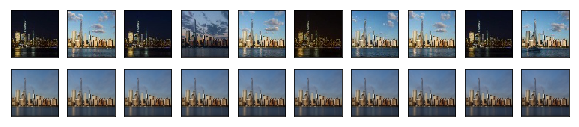

In [46]:
img_size = 64

# following values can generate some good skyline images
grid_x = norm.ppf(np.linspace(0.05, 0.95, n))
grid_y = norm.ppf(np.linspace(0.05, 0.95, n))

#samples_encoded = [[5.55, -3.33], [-1.11, 10], [120, 13.3], [33.33, -77.77], [11.11, -33.33], [11.11, 11.11], [100, -33.33], [-7.77, -1.11], [-33.33, -11.11], [-33.33, 11.11]]
samples         = x_test[15:25]


# code to create a result.png with generated faces
plt.figure(figsize=(10, 2))

for i, yi in enumerate(grid_x):
    for j, xi in enumerate(grid_y):
        z_sample = np.array([[xi, yi]])
        x_decoded = generator.predict(z_sample)
        x_decoded = x_decoded
        #print x_decoded.shape
        face = x_decoded[0].reshape(img_size, img_size, 3)


        ax1 = plt.subplot(2, 10, i + 1)
        plt.imshow(samples[i].reshape(img_size, img_size, 3))
        ax1.get_xaxis().set_visible(False)
        ax1.get_yaxis().set_visible(False)

        ax = plt.subplot(2, 10, i + 10 + 1)
        plt.imshow(face)
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)



plt.savefig('result.png')
#plt.show()